# Citibike-Exploratory-Analysis
## by Charles Ikenna Abara

## Introduction
Citi Bike is the nation's most extensive bike share program, with 20,000 bikes and over 1,300 stations. This data includes information about individual rides made in a bike-sharing system covering Manhattan, Brooklyn, Queens, the Bronx, and Jersey City. The dataset consists of bike-sharing data from 2014 to 2016.

## Preliminary Wrangling

In [3]:
# Import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os
import glob

%matplotlib inline

In [4]:

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
filepaths = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        filepaths.append(os.path.join(dirname, filename))

In [5]:
# Load the dataset
columns = ['duration', 'start_time', 'stop_time', 'start_station_id', 'start_station_name',
           'start_station_latitude', 'start_station_longitude', 'end_station_id', 'end_station_name',
          'end_station_latitude', 'end_station_longitude', 'bikeid', 'usertype', 'user_birth_year',
           'user_gender']
citibike = pd.concat((pd.read_csv(f, names=columns, header=0, low_memory=False) for f in filepaths), ignore_index = True)

**Define Helper functions**

In [6]:
# Helper functions
def millions(x, pos):
    """The two arguments are the value and tick position."""
    return '{:1.1f}M'.format(x*1e-6)

def add_pct(data, ax):
    """ Add percentage to bars of bar plot """
    total = sum(data)
    for p in ax.patches:
        pct = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2
        y = p.get_y() + p.get_height() + 0.02
        ax.annotate(pct, (x, y))
    return


# ------------------------------------------------------------------------------------
# Define function that converts columns with multiple date-time formats to datetime object
def str_to_datetime(df, col: str):
    """
    convert column to datetime object
    """
    # part 1
    df["temp1"] = pd.to_datetime(df[col], format='%m/%d/%Y %H:%M:%S', errors='coerce')
    df["temp2"] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S', errors='coerce')
    df["temp3"] = pd.to_datetime(df[col], format='%m/%d/%Y %H:%M', errors='coerce')

    # part 2
    df[col] = np.where(~df["temp1"].isnull(), df["temp1"], df["temp2"])
    df[col] = np.where(~df["temp3"].isnull(), df["temp3"], df[col])

    # part 3
    return df.drop(columns=['temp1', 'temp2', 'temp3'])


In [7]:
# print dimentionality of dataframe
citibike.shape

(31864840, 15)

In [8]:
# preview data content
citibike.head()

,duration,start_time,stop_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,user_birth_year,user_gender
0,923,1/1/2016 00:00:41,1/1/2016 00:16:04,268,Howard St & Centre St,40.719105,-73.999733,3002,South End Ave & Liberty St,40.711512,-74.015756,22285,Subscriber,1958.0,1
1,379,1/1/2016 00:00:45,1/1/2016 00:07:04,476,E 31 St & 3 Ave,40.743943,-73.979661,498,Broadway & W 32 St,40.748549,-73.988084,17827,Subscriber,1969.0,1
2,589,1/1/2016 00:00:48,1/1/2016 00:10:37,489,10 Ave & W 28 St,40.750664,-74.001768,284,Greenwich Ave & 8 Ave,40.739017,-74.002638,21997,Subscriber,1982.0,2
3,889,1/1/2016 00:01:06,1/1/2016 00:15:56,268,Howard St & Centre St,40.719105,-73.999733,3002,South End Ave & Liberty St,40.711512,-74.015756,22794,Subscriber,1961.0,2
4,1480,1/1/2016 00:01:12,1/1/2016 00:25:52,2006,Central Park S & 6 Ave,40.765909,-73.976342,2006,Central Park S & 6 Ave,40.765909,-73.976342,14562,Subscriber,1952.0,1


In [9]:
citibike.tail()

,duration,start_time,stop_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,user_birth_year,user_gender
31864835,536,3/31/2015 23:58,4/1/2015 0:07,324,DeKalb Ave & Hudson Ave,40.689888,-73.981013,421,Clermont Ave & Park Ave,40.695734,-73.971297,19615,Subscriber,1985.0,1
31864836,1030,3/31/2015 23:59,4/1/2015 0:16,495,W 47 St & 10 Ave,40.762699,-73.993012,404,9 Ave & W 14 St,40.740583,-74.005509,15086,Subscriber,1978.0,1
31864837,171,3/31/2015 23:59,4/1/2015 0:02,450,W 49 St & 8 Ave,40.762272,-73.987882,479,9 Ave & W 45 St,40.760193,-73.991255,18943,Subscriber,1986.0,1
31864838,616,3/31/2015 23:59,4/1/2015 0:09,455,1 Ave & E 44 St,40.750020,-73.969053,477,W 41 St & 8 Ave,40.756405,-73.990026,21364,Subscriber,1970.0,1
31864839,227,3/31/2015 23:55,3/31/2015 23:59,477,W 41 St & 8 Ave,40.756405,-73.990026,478,11 Ave & W 41 St,40.760301,-73.998842,16020,Subscriber,1998.0,1


In [10]:
# print a concise summary of Dataframe
citibike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31864840 entries, 0 to 31864839
Data columns (total 15 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   duration                 int64  
 1   start_time               object 
 2   stop_time                object 
 3   start_station_id         int64  
 4   start_station_name       object 
 5   start_station_latitude   float64
 6   start_station_longitude  float64
 7   end_station_id           int64  
 8   end_station_name         object 
 9   end_station_latitude     float64
 10  end_station_longitude    float64
 11  bikeid                   int64  
 12  usertype                 object 
 13  user_birth_year          object 
 14  user_gender              int64  
dtypes: float64(4), int64(5), object(6)
memory usage: 3.6+ GB


In [11]:
# check for null values
citibike.isnull().sum()

duration                         0
start_time                       0
stop_time                        0
start_station_id                 0
start_station_name               0
start_station_latitude           0
start_station_longitude          0
end_station_id                   0
end_station_name                 0
end_station_latitude             0
end_station_longitude            0
bikeid                           0
usertype                     35871
user_birth_year            3111175
user_gender                      0
dtype: int64

In [12]:
# Count number of distinct elements in each feature
citibike.nunique()

duration                      47369
start_time                 22108845
stop_time                  22162317
start_station_id                662
start_station_name              688
start_station_latitude          706
start_station_longitude         706
end_station_id                  689
end_station_name                715
end_station_latitude            734
end_station_longitude           735
bikeid                        11771
usertype                          2
user_birth_year                 181
user_gender                       3
dtype: int64

In [13]:
# check for duplicates
citibike.duplicated(subset=["start_time", "stop_time", "bikeid"]).sum()

5

In [14]:
# drop duplicates
citibike = citibike[~citibike.duplicated(subset=["start_time", "stop_time", "bikeid"])]

I'll start by converting `start_time` and `stop_time` to datetime objects. This will facilitate future analysis. I observed that three distinct datetime formats were used in this columns. The pandas `to_datetime` function will be notoriously slow if the data format is not explictily specified but would raise an error if the format specified does not march a value in the column. For speed efficiency, I will break the conversion process into two parts for each date format and combine the output of all parts.

In [15]:
%%time
citibike = str_to_datetime(citibike, "start_time")
citibike = str_to_datetime(citibike, "stop_time")

CPU times: user 3min 23s, sys: 8.96 s, total: 3min 32s
Wall time: 3min 31s


Next I'll convert the `user_birth_year column` to int data type. Some values in this column are non numeric, so i'll start by replacing those values with NaN, and finally convert to int dtype

In [16]:
citibike.user_birth_year = pd.to_numeric(citibike.user_birth_year, errors='coerce').astype('Int32')

Transform duration from seconds to minutes

The `user_gender` will be be converted to categorial dtype and the column name will be changed to `gender`

In [17]:
# convert user_gender to categorical type
citibike["gender"] = citibike.user_gender.astype('category')
citibike.drop(columns=["user_gender"], inplace=True)

In [18]:
citibike.duration = citibike.duration.div(60).round(2)

Check for and remove outliers if any. These outliers can be caused by either incorrect data collection or genuine outlying observations.

In [19]:
# check for outliers
citibike['duration'].describe(percentiles = [0.25, 0.50, 0.75, 0.95, 0.99]).round(2)

count    31864835.00
mean           15.58
std           134.16
min             1.00
25%             6.43
50%            10.43
75%            17.48
95%            33.40
99%            63.13
max        148892.53
Name: duration, dtype: float64

There seem to be outliers in the trip duration. I will Remove the values which are above the 99th percentile

In [20]:
citibike = citibike[citibike.duration <= 63.13]

I will be making use of the start and end station names hence there will be no need for the station id columns. `end_station_id` and `start_station_id` will be droped. `start_station_longitude`, `start_station_latitude`, `stop_station_longitude` and `end_station_latitude` will also be droped as they will not be necessary for my analysis.

In [21]:
# drop columns
citibike = citibike.drop(columns=["start_station_id", "end_station_id", "start_station_longitude", "start_station_latitude",
            "end_station_longitude", "end_station_latitude"])

In [22]:
# sort dataframe by start_time and reset index
citibike = citibike.sort_values(by='start_time').reset_index(drop=True)

**Reaccessing the dataframe to confirm changes**

In [23]:
citibike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31546302 entries, 0 to 31546301
Data columns (total 9 columns):
 #   Column              Dtype         
---  ------              -----         
 0   duration            float64       
 1   start_time          datetime64[ns]
 2   stop_time           datetime64[ns]
 3   start_station_name  object        
 4   end_station_name    object        
 5   bikeid              int64         
 6   usertype            object        
 7   user_birth_year     Int32         
 8   gender              category      
dtypes: Int32(1), category(1), datetime64[ns](2), float64(1), int64(1), object(3)
memory usage: 1.8+ GB


In [24]:
citibike.tail()

,duration,start_time,stop_time,start_station_name,end_station_name,bikeid,usertype,user_birth_year,gender
31546297,7.35,2016-12-31 23:56:15,2017-01-01 00:03:36,Greenwich Ave & 8 Ave,Sullivan St & Washington Sq,16185,Subscriber,1974,2
31546298,17.10,2016-12-31 23:56:19,2017-01-01 00:13:26,Grand Army Plaza & Central Park S,5 Ave & E 78 St,18267,NaN,1983,1
31546299,29.12,2016-12-31 23:56:35,2017-01-01 00:25:43,E 106 St & Lexington Ave,Central Park W & W 96 St,19899,Subscriber,1970,2
31546300,15.85,2016-12-31 23:59:31,2017-01-01 00:15:23,W 63 St & Broadway,Riverside Dr & W 82 St,16866,Subscriber,1961,1
31546301,22.03,2016-12-31 23:59:56,2017-01-01 00:21:58,Cooper Square & E 7 St,Broadway & W 32 St,25793,Subscriber,1985,1


In [25]:
# save wrangled data
#citibike.to_csv("citibike-wrangled.csv", index=False)

### What is the structure of your dataset?

The wrangled dataset consists of bike-sharing data in New york city from January 2014 to December 2016. Some bike rides on 31 December 2016 ended in 2017. The data set has 31546302 rows and 9 features. The features are listed below:
* Trip Duration(minutes):**duration**
* Start Time and Date: **start_time**
* Start Station Name: **start_station_name**
* Stop Time and Date: **stop_time**
* End Station Name: **end_station_name**
* Bike ID: **bike_id**
* User Type (Customer = 24-hour pass or 3-day pass user; Subscriber = Annual Member): **usertype**
* Gender (Zero=unknown; 1=male; 2=female): **gender**
* Year of Birth: **user_birth_year**

### What is/are the main feature(s) of interest in your dataset?
 My main feature of interest is Trip Duration. All my analysis will revolve around this feature

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

The start_time and end_time would support my investigation into duration. I will use time series plots to analyze which months, days of the week and hour of the day most rides are taken. The categorical variables would also be used to investigate trends and patterns in duration.

## Univariate Exploration


#### duration
I'll start by looking into the main variablr of interest: duration

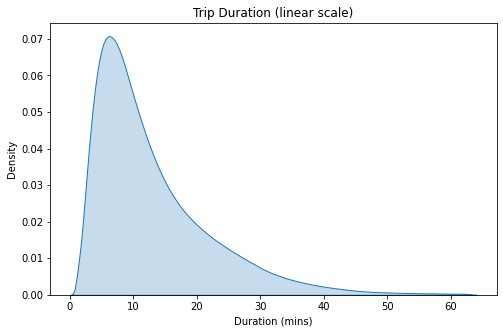

In [26]:
fig = plt.figure(figsize=[8, 5])
ax = sns.kdeplot(citibike["duration"], shade=True)
ax.set_title("Trip Duration (linear scale)")
ax.set_xlabel("Duration (mins)")

plt.show()

The density distribution plot when plotted with a linear scale was skewed to the right.

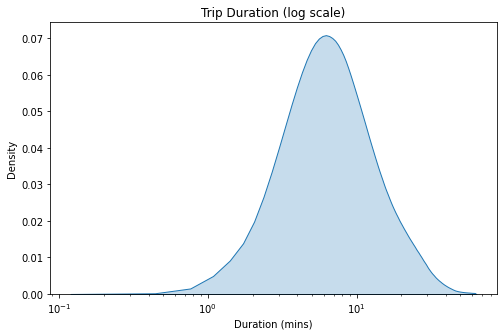

In [27]:
fig = plt.figure(figsize=[8, 5])
ax = sns.kdeplot(citibike["duration"], shade=True)
ax.set_title("Trip Duration (log scale)")
ax.set_xlabel("Duration (mins)")
ax.set_xscale('log')

plt.show()

#### Start station

In the next two sub sections I will try to analyze which stations are most popular.

In [28]:
start_stations = citibike.groupby("start_station_name").size().sort_values(ascending=False)
start_stations.size

688

There are over 688 start stations in this dataset. I will look at the top 20 based on the number of bike rides that originated and finished at each station.

In [29]:
start_stations = start_stations[:20]

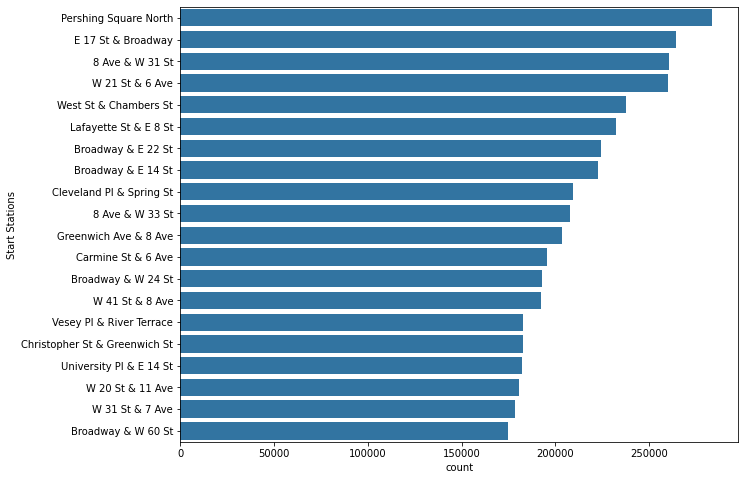

In [30]:
fig = plt.figure(figsize=[10, 8])
ax = sns.barplot(x=start_stations, y=start_stations.index, color=sns.color_palette()[0])
ax.set_xlabel("count")
ax.set_ylabel("Start Stations")

plt.show()

#### End stations

In [31]:
end_stations = citibike.groupby("end_station_name").size().sort_values(ascending=False)[:20]

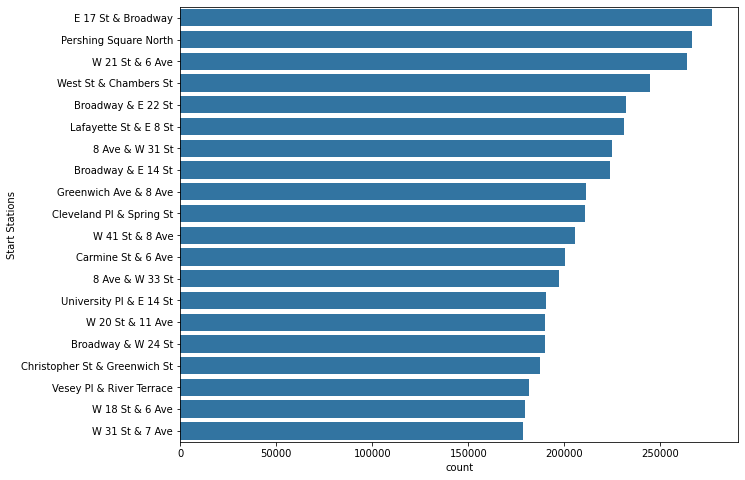

In [32]:
fig = plt.figure(figsize=[10, 8])
ax = sns.barplot(x=end_stations, y=end_stations.index, color=sns.color_palette()[0])
ax.set_xlabel("count")
ax.set_ylabel("Start Stations")

plt.show()

#### When are rides taken
In this section, I will try to answer the following questions; What days of the week are most rides taken on? What days of the month are most rides taken on? and what months of the year are most rides taken on?

I will use the "start_time" as the feature to look into what time of day, day of week, day of month and
month of year most rides we started

In [33]:
rides_per_hour = citibike.start_time.dt.hour.value_counts(sort=False)

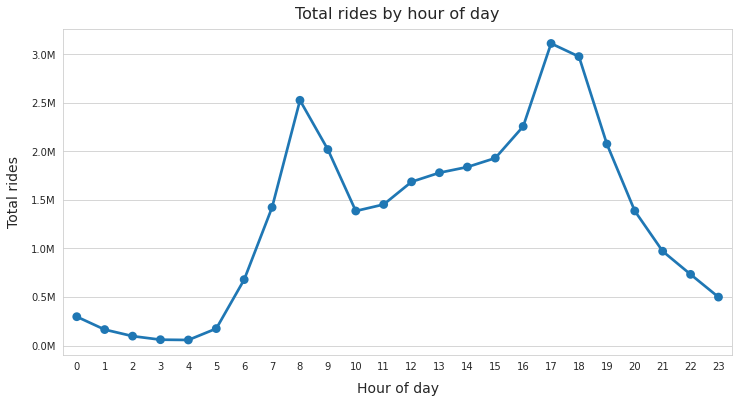

In [34]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=[12, 6])
ax = sns.pointplot(x=rides_per_hour.index, y=rides_per_hour)
ax.set_xlabel("Hour of day", fontsize=14, labelpad=10)
ax.set_ylabel("Total rides", fontsize=14, labelpad=10)
ax.set_title("Total rides by hour of day", fontsize=16, pad=10)
ax.yaxis.set_major_formatter(millions)

plt.show()

The point plot shows a low number of bike rides at night(0:00-06:00). There is a sharp increase in the number of bike rides from 6 am, which maxes out at 8 am, drops from 8 am to 10 am, then increases gradually. There is another sharp drop between 6 pm (18:00) to 11 pm (23:00). Generally, It seems there are more bike rides during the day and fewer bike rides at night.

In [35]:
rides_per_weekday = citibike.start_time.dt.day_name().value_counts(sort=False)

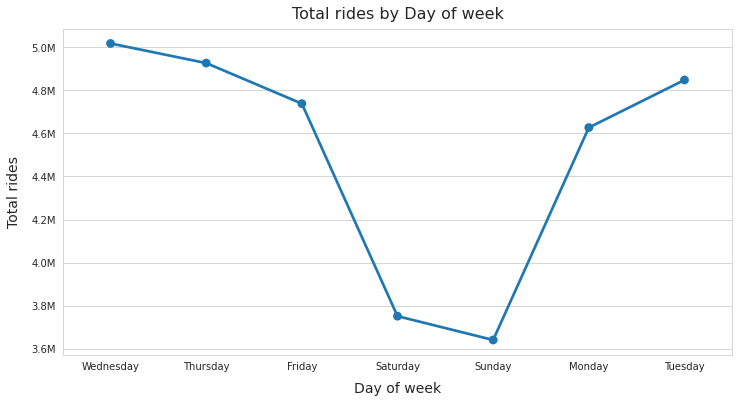

In [36]:
sns.axes_style("whitegrid")
plt.figure(figsize=[12, 6])
ax = sns.pointplot(x=rides_per_weekday.index, y=rides_per_weekday)
ax.set_xlabel("Day of week", fontsize=14, labelpad=10)
ax.set_ylabel("Total rides", fontsize=14, labelpad=10)
ax.set_title("Total rides by Day of week", fontsize=16, pad=10)
ax.yaxis.set_major_formatter(millions)

plt.show()

From the point plot above, we can see that  Saturday and Sunday had the lest number of bike rides.

In [37]:
rides_per_day = citibike.start_time.dt.day.value_counts(sort=False)

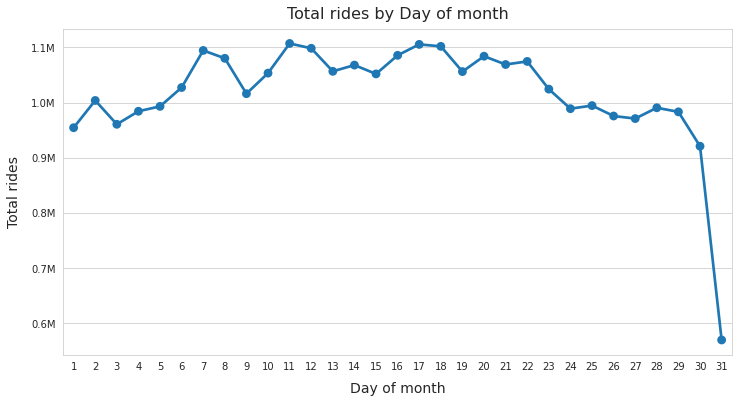

In [38]:
sns.axes_style("whitegrid")
fig = plt.figure(figsize=[12, 6])
ticks = np.arange(1, 32, 1)
ax = sns.pointplot(x=rides_per_day.index, y=rides_per_day, order=ticks)
ax.set_xlabel("Day of month", fontsize=14, labelpad=10)
ax.set_ylabel("Total rides", fontsize=14, labelpad=10)
ax.set_title("Total rides by Day of month", fontsize=16, pad=10)
ax.yaxis.set_major_formatter(millions)

plt.show()

The total number of bike rides for each day of the month was highly varied.

In [39]:
# total rides by month
rides_per_month = citibike.start_time.dt.month_name().value_counts(sort=False)

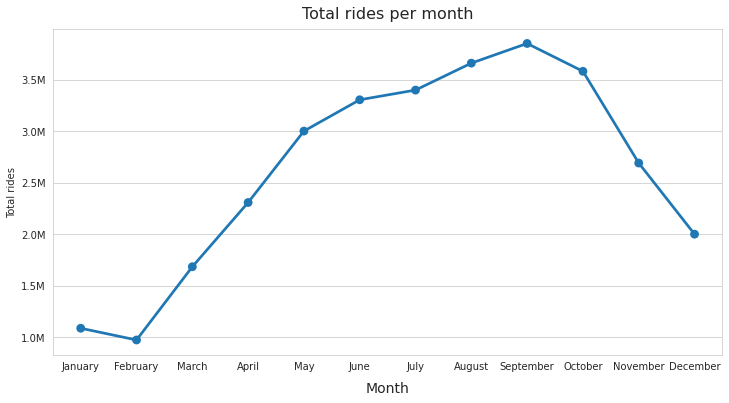

In [40]:
# plot point plot
fig = plt.figure(figsize=[12, 6])
ax = sns.pointplot(x=rides_per_month.index, y=rides_per_month)
ax.set_xlabel("Month", labelpad=10, fontsize=14)
ax.set_ylabel("Total rides")
ax.set_title("Total rides per month", fontsize=16, pad=10)
ax.yaxis.set_major_formatter(millions)

plt.show()

There was a steady increase in the number of bike rides from February which maxed out in September then declined from September to December.

In [41]:
rides_per_year = citibike.start_time.dt.year.value_counts(sort=False)

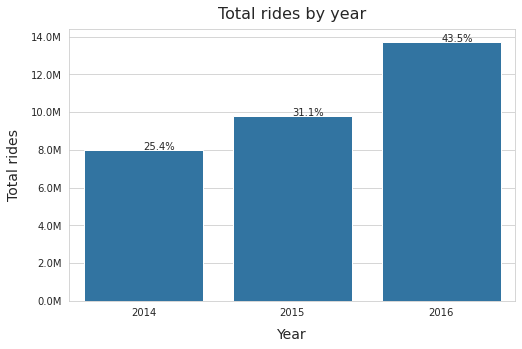

In [42]:
fig = plt.figure(figsize=[8, 5])
ax = sns.barplot(x=rides_per_year.index, y=rides_per_year, color=sns.color_palette()[0])
ax.set_xlabel("Year", fontsize=14, labelpad=10)
ax.set_ylabel("Total rides", fontsize=14, labelpad=10)
ax.set_title("Total rides by year", fontsize=16, pad=10)
ax.yaxis.set_major_formatter(millions)

add_pct(rides_per_year, ax)

plt.show()

There is an increase in total bike rides from 2014 to 2016.

#### User type & user gender

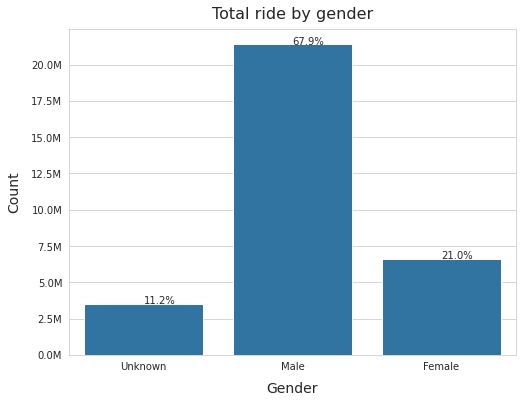

In [43]:
fig = plt.figure(figsize=[8, 6])
ax = sns.countplot(data=citibike, x='gender', color=sns.color_palette()[0])
ax.set_xlabel("Gender", fontsize=14, labelpad=10)
ax.set_xticklabels(["Unknown", "Male", "Female"])
ax.set_ylabel("Count", fontsize=14, labelpad=10)
ax.set_title("Total ride by gender", fontsize=16, pad=10)
ax.yaxis.set_major_formatter(millions)
add_pct(citibike.gender.value_counts(), ax)


plt.show()

67.9% of all rides were by male customers, 21.0% were by femal customers while the gender of 11.2% is unknown.

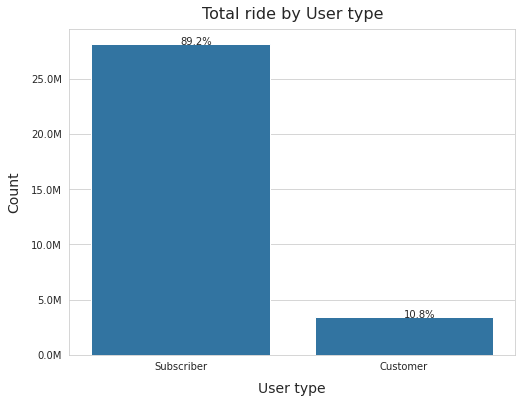

In [44]:
fig = plt.figure(figsize=[8, 6])
ax = sns.countplot(data=citibike, x='usertype', color=sns.color_palette()[0])
ax.set_xlabel("User type", fontsize=14, labelpad=10)
ax.set_ylabel("Count", fontsize=14, labelpad=10)
ax.set_title("Total ride by User type", fontsize=16, pad=10)
ax.yaxis.set_major_formatter(millions)
add_pct(citibike.usertype.value_counts(), ax)


plt.show()

The bar plot above shows that 89.2% of all rides were by subscribers, while just 10.8% were by customers. This could indicate that the 24-hours pass and the 3-days pass are much more popular than the annual membership package.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

The distribution of duration was skewed to the right. This means that most values fall under the lower bound but with a long tail of values that are high.i.e mode < mean. After transforming the scale for the x axis from linear to log the distribution became symmetrical.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

There were no irregularities in the features I investigated.  

## Bivariate Exploration

In [45]:
male = citibike[citibike['gender']== 1]
female = citibike[citibike['gender'] == 2]

male_rides_per_hour = male.start_time.dt.hour.value_counts(sort=False)
female_rides_per_hour = female.start_time.dt.hour.value_counts(sort=False)

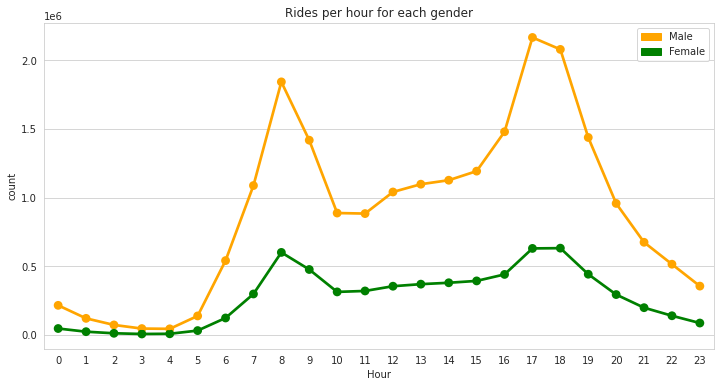

In [46]:
plt.figure(figsize=[12, 6])
male = sns.pointplot(x=male_rides_per_hour.index, y=male_rides_per_hour, color='orange')
female = sns.pointplot(x=female_rides_per_hour.index, y=female_rides_per_hour, color='green')
plt.xlabel("Hour")
plt.ylabel("count")
plt.title("Rides per hour for each gender")

# add legend
patch1 = mpatches.Patch(color='orange', label='Male')
patch2 = mpatches.Patch(color='green', label='Female')
plt.legend(handles=[patch1, patch2])

plt.show()

The pattern for number of rides by hour is similar for both male and femal gender. 

In [47]:
subscriber = citibike[citibike.usertype == "Subscriber"]
customer = citibike[citibike.usertype == "Customer"]

subscriber_rides_per_hour = subscriber.start_time.dt.hour.value_counts(sort=False)
customer_rides_per_hour = customer.start_time.dt.hour.value_counts(sort=False)

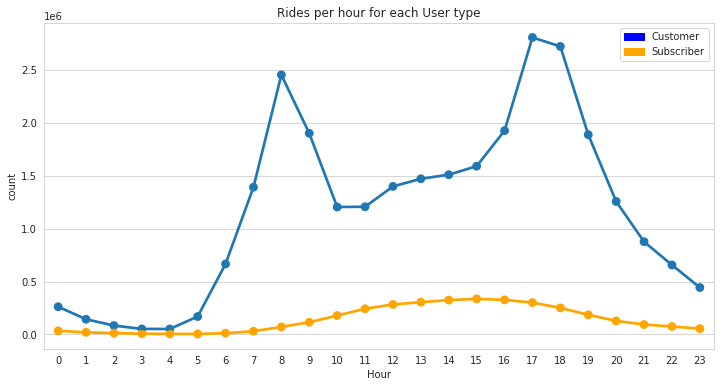

In [48]:
plt.figure(figsize=[12, 6])
sns.pointplot(x=subscriber_rides_per_hour.index, y=subscriber_rides_per_hour)
sns.pointplot(x=customer_rides_per_hour.index, y=customer_rides_per_hour, color='orange')
plt.xlabel("Hour")
plt.ylabel("count")
plt.title("Rides per hour for each User type")

# add legend
patch1 = mpatches.Patch(color='blue', label='Customer')
patch2 = mpatches.Patch(color='orange', label='Subscriber')
plt.legend(handles=[patch1, patch2])

plt.show()

There is a noticeable difference in bike rides per hour between customers and subscribers.

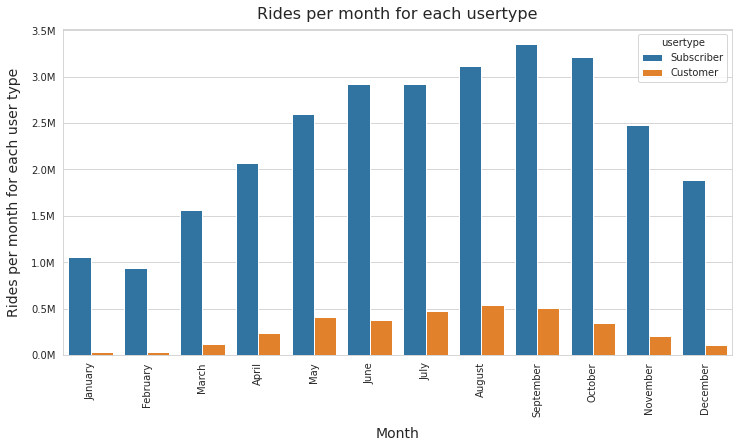

In [49]:
# rides per month for each user type
plt.figure(figsize=[12, 6])
ax = sns.countplot(data=citibike, x=citibike.start_time.dt.month_name(), hue="usertype")
ax.set_xlabel("Month", fontsize=14, labelpad=10)
ax.set_ylabel("Rides per month for each user type", fontsize=14, labelpad=10)
ax.set_title("Rides per month for each usertype", fontsize=16, pad=10)
ax.yaxis.set_major_formatter(millions)
plt.xticks(rotation=90)


plt.show()

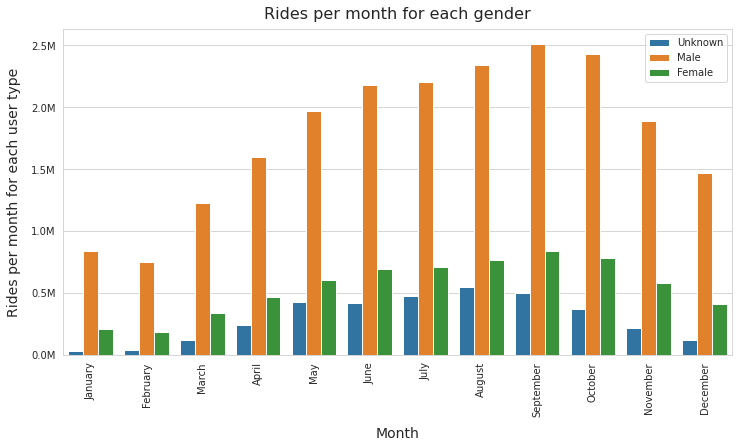

In [50]:
# Rides per month for each gender
plt.figure(figsize=[12, 6])
ax = sns.countplot(data=citibike, x=citibike.start_time.dt.month_name(), hue="gender")
ax.set_xlabel("Month", fontsize=14, labelpad=10)
ax.set_ylabel("Rides per month for each user type", fontsize=14, labelpad=10)
ax.set_title("Rides per month for each gender", fontsize=16, pad=10)
ax.yaxis.set_major_formatter(millions)
plt.xticks(rotation=90)

# customis labels
plt.legend(["Unknown", "Male", "Female"])

plt.show()

#### Duration vs User Type

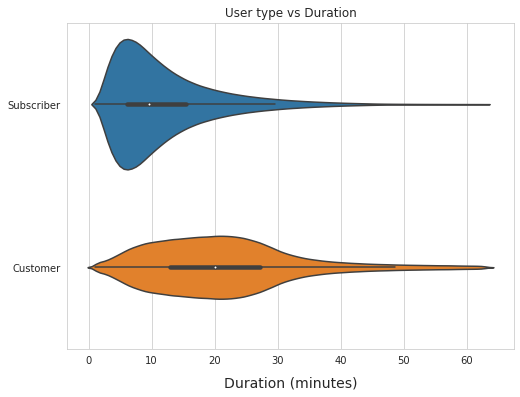

In [51]:
fig = plt.figure(figsize=[8, 6])
ax = sns.violinplot(data=citibike, x="duration", y="usertype")
ax.set_xlabel("Duration (minutes)", fontsize=14, labelpad=10)
ax.set_ylabel("")
ax.set_title("User type vs Duration")

plt.show()

The violin plot shows that the distributions for ride duration for both male and female riders are similar. The violin plot above shows that Subscribers have a higher probability of taking shorter rides while there is more variance in the ride duration for customers.

#### duration vs gender

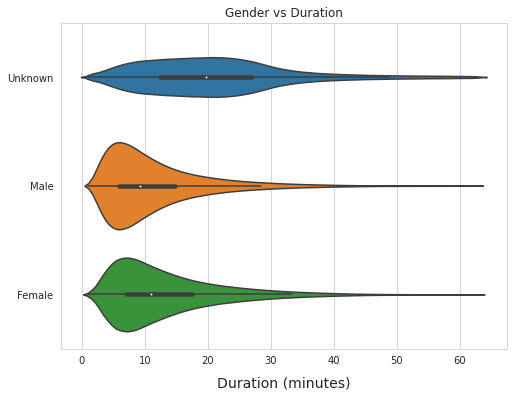

In [52]:
fig = plt.figure(figsize=[8, 6])
ax = sns.violinplot(data=citibike, x="duration", y="gender")
ax.set_xlabel("Duration (minutes)", fontsize=14, labelpad=10)
ax.set_ylabel("")
ax.set_yticklabels(["Unknown", "Male", "Female"])
ax.set_title("Gender vs Duration")

plt.show()

The violin plot shows that the distributions for ride duration for both male and female riders are similar.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

In this section I studied the effects of user type and user gender on `duration`. There was consistency in the distribution of bike rides by month for each gender and user type. The nature of rides per hour varied for subscribers and customers.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?
The violin plot of duration vs user type showed that subscribers to shorter rides while custormers had a wider spread of values.

## Multivariate Exploration

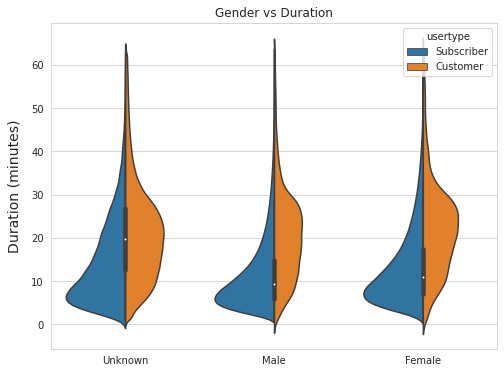

In [53]:
fig = plt.figure(figsize=[8, 6])
ax = sns.violinplot(data=citibike, x="gender", y="duration", hue="usertype", split=True)
ax.set_ylabel("Duration (minutes)", fontsize=14, labelpad=10)
ax.set_xlabel("")
ax.set_xticklabels(["Unknown", "Male", "Female"])
ax.set_title("Gender vs Duration")

plt.show()

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?
The findings from the multivariate analysis are consistent with the findings of the univariate and bivariate analysis. Citibike riders who are subscribers regardless of gender had shorter ride durations, while custormers had a wider range in duration values.
### Were there any interesting or surprising interactions between features?

There were no suprising interactions between features.

## Conclusions
There was a substantial Increase in bike rides from 2014 to 2016. This increase could indicate company growth and an increase in total citibike users. A line plot of bike rides per hour showed that there were more rides during the day than at night. The bivariate and multivariate exploration investigated the effect of user type and gender on duration. 